In [44]:
import seaborn as sns
import plotly.graph_objects as go
from scipy.optimize import minimize
%matplotlib inline

import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt
%matplotlib inline
import os

# 1. Подготовка временного ряда

В качестве первого домашнего задания предлагалось научиться загружать данные и, пользуясь возможностями рассмотренных на занятии библиотек NumPy и Pandas, провести некоторые преобразования над ними. Рассмотрим пример решения на данных об объемах пассажирских авиаперевозок.

In [2]:
passengers = pd.read_csv('passengers.csv', index_col=0, parse_dates=True)

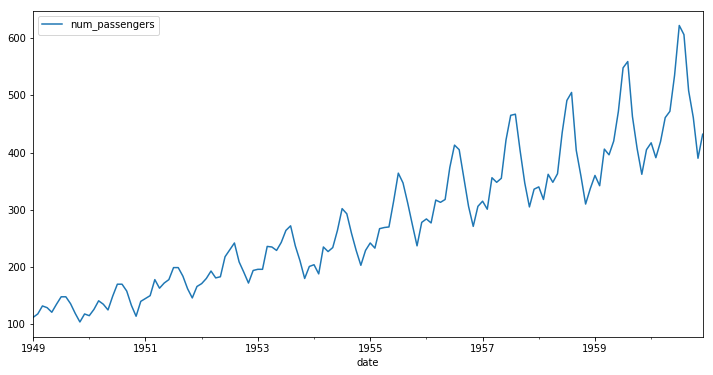

In [3]:
passengers.plot(figsize=(12,6))
plt.show()

Как было отмечено ранее, представленный временной ряд не является стационарным. В нем наблюдаются как тренд, так и сезонность. Кроме того, дисперсия на разных участках ряда непостоянна. Поэтому сначала выполним преобразование Бокса-Кокса.

## 1.1. Преобразование Бокса-Кокса

In [4]:
def boxcox(lmbda, x):
    if lmbda == 0:
        return np.log(x)
    
    return (x**(lmbda) - 1) / lmbda

In [5]:
def boxcox_llf(data,lmbda):
    #Посчитаем среднее значение преобразования Бокса-Кокса
    sredn = np.sum([boxcox(lmbda,x) for x in data]) / len(data)
    #Сумма отклонений
    sums = np.sum(([boxcox(lmbda,x) for x in data] - sredn)**2)
    #Логафрим функции правдоподобия, взятый с обратным знаком, чтобы минимизировать, 
    #а не максимизировать функцию
    ln_L = np.sum([np.log(x) for x in data])*(lmbda - 1) - len(data)/2 * np.log(sums/len(data))
    return ln_L

Еще один вид реализации

In [6]:
def boxcox_llf_2(y, lmbda):
    return (lmbda - 1)*np.sum(np.log(y)) - (y.shape[0] / 2)*np.log(np.sum((boxcox(y, lmbda) - 
                                                                    boxcox(y, lmbda).mean())**2 / y.shape[0]))

В домашнем задании предлагалось выбрать коэффициент $\lambda$ из 100 возможных значений, которые можно получить с помощью рассмотренной функции `np.linspace`.

In [7]:
lmbda_list = np.linspace(0, 1, 100)

In [8]:
llf_res = [boxcox_llf(passengers['num_passengers'], lmbda) for lmbda in lmbda_list]
idx = np.argmax(llf_res)

In [9]:
lmbda_list[idx], llf_res[idx]

(0.15151515151515152, -679.5432888650778)

Среди возможных значений `lmbda_list` максимальное значение функции правдоподобия достигается при $\lambda=0.15$. Для получения более точного значения воспользуемся функцией `scipy.optimize.minimize`. Здесь оптимизируемый параметр можно передать через lambda-функцию и, поскольку необходимо найти максимум правдоподобия, передадим в качестве оптимизируемой функции `-boxcox_llf(y, lmbda)`.

In [10]:
from scipy.optimize import minimize
res = minimize(lambda x: -boxcox_llf(passengers['num_passengers'], x), 1)
res

      fun: 679.5431311684138
 hess_inv: array([[0.03868383]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([0.14802242])

Преобразование Бокса-Кокса реализовано также в пакете **SciPy** в виде функций с аналогичными названиями: 
- `scipy.stats.boxcox` принимает на вход временной ряд, а возвращает преобразованный ряд и значение $\lambda$, при котором достигается максимум правдоподобия;
- `scipy.stats.boxcox_llf` возвращает значение функции правдоподобия.

In [11]:
from scipy.stats import boxcox, boxcox_llf

In [12]:
passengers_transformed, lmbda = boxcox(passengers['num_passengers'])

In [13]:
lmbda # верное lambda

0.14802265137037945

In [14]:
boxcox_llf(lmbda, passengers['num_passengers']) # функция правдоподобия

-679.5431311684133

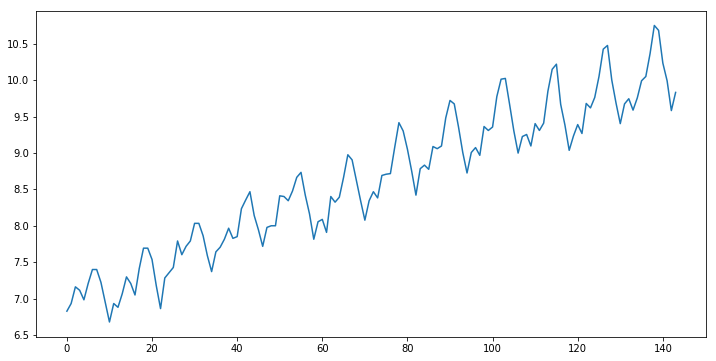

In [15]:
plt.figure(figsize=(12,6))
plt.plot(passengers_transformed)
plt.show()

Дисперсия стабилизировалась. Теперь необходимо избавиться от тренда и сезонности.

## 1.2. Дифференцирование

Для дифференцирования временного ряда в Pandas есть функция `pd.Series.diff(lag)`. Преобразуем предварительно полученные значения обратно в `pd.DataFrame()`, а затем проведем сезонное дифференцирование.

In [16]:
y_transformation = pd.DataFrame(passengers['num_passengers'].values, columns=['initial'])
y_transformation['transformed'] = passengers_transformed
y_transformation.head()

initial  transformed
0      112     6.827490
1      118     6.932822
2      132     7.161892
3      129     7.114611
4      121     6.983787

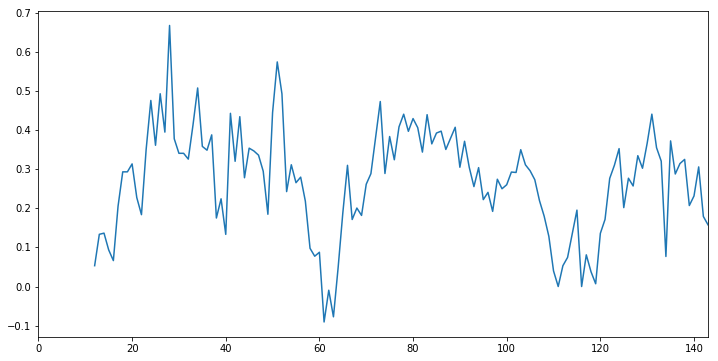

In [17]:
y_transformation['seasonal_diff'] = y_transformation['transformed'].diff(12)
y_transformation['seasonal_diff'].plot(figsize=(12,6))
plt.show()

In [18]:
y_transformation.head(15)

initial  transformed  seasonal_diff
0       112     6.827490            NaN
1       118     6.932822            NaN
2       132     7.161892            NaN
3       129     7.114611            NaN
4       121     6.983787            NaN
5       135     7.208265            NaN
6       148     7.399598            NaN
7       148     7.399598            NaN
8       136     7.223528            NaN
9       119     6.949932            NaN
10      104     6.679301            NaN
11      118     6.932822            NaN
12      115     6.880741       0.053251
13      126     7.066384       0.133562
14      141     7.298438       0.136547

In [19]:
y_transformation['lag1_diff'] = y_transformation['seasonal_diff'].diff(1)

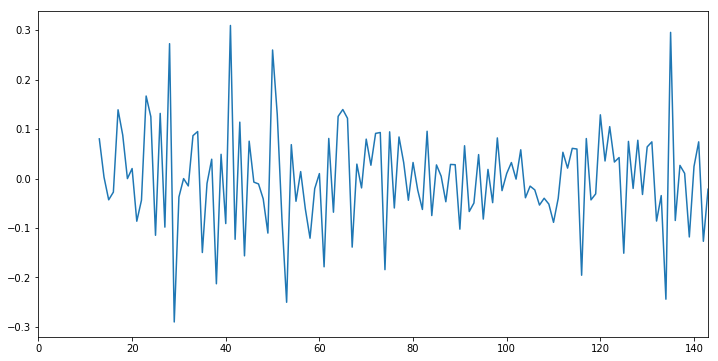

In [20]:
y_transformation['lag1_diff'].plot(figsize=(12,6))
plt.show()

In [21]:
from statsmodels.graphics.tsaplots import plot_acf
# в прежней версии statsmodels.graphics.tsa import plot_acf

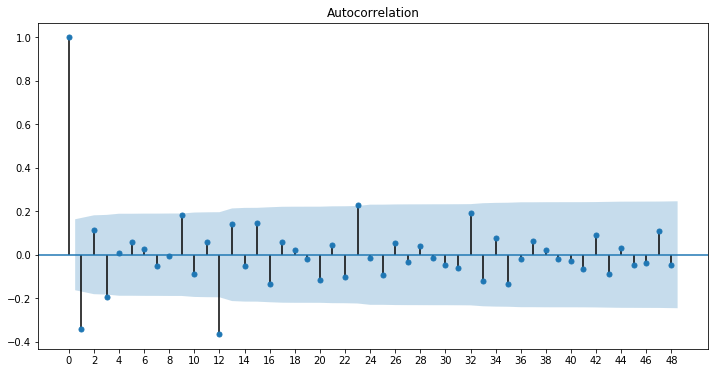

In [22]:
plt.rcParams['figure.figsize'] = (12,6)
2
plot_acf(y_transformation['lag1_diff'].fillna(0).values, lags=48)
3
plt.xticks(np.arange(0, 50, 2))
4
plt.show()


Слетело первых 12 значений

Большая часть значений лежит внутри "коридора", ряд можно считать стационарным.

## 1.3. Обратное преобразование

В дальнейшем нам понадобится проводить дифференцирование ряда для построения прогноза. Однако, от такого прогноза будет мало толку, ведь полученный ряд будет содержать такие же преобразованные значения. Поэтому необходимо последовательно вернуться к ряду исходных значений.

In [23]:
y_transformation.head(15)

initial  transformed  seasonal_diff  lag1_diff
0       112     6.827490            NaN        NaN
1       118     6.932822            NaN        NaN
2       132     7.161892            NaN        NaN
3       129     7.114611            NaN        NaN
4       121     6.983787            NaN        NaN
5       135     7.208265            NaN        NaN
6       148     7.399598            NaN        NaN
7       148     7.399598            NaN        NaN
8       136     7.223528            NaN        NaN
9       119     6.949932            NaN        NaN
10      104     6.679301            NaN        NaN
11      118     6.932822            NaN        NaN
12      115     6.880741       0.053251        NaN
13      126     7.066384       0.133562   0.080310
14      141     7.298438       0.136547   0.002985

Перейдем от ряда `lag1_diff` к ряду `seasonal_diff`. В таблице выше это означает, что к `0.080310` необходимо пребавить `0.053251`, к `0.002985` - `0.133562` и т. д. Сдвинем ряд на одно значение с помощью функции `pd.Series.shitf(lag)`:

In [24]:
y_transformation['seasonal_diff_shift'] = y_transformation['seasonal_diff'].shift()
y_transformation.head()

initial  transformed  seasonal_diff  lag1_diff  seasonal_diff_shift
0      112     6.827490            NaN        NaN                  NaN
1      118     6.932822            NaN        NaN                  NaN
2      132     7.161892            NaN        NaN                  NaN
3      129     7.114611            NaN        NaN                  NaN
4      121     6.983787            NaN        NaN                  NaN

Теперь сложим два полученных ряда, чтобы вернуться к ряду `seasonal_diff` и удалим вспомогательный столбец `seasonal_diff_shift`:

In [25]:
y_transformation['seasonal_diff_res'] = y_transformation['lag1_diff'] + y_transformation['seasonal_diff_shift']
y_transformation.drop(['seasonal_diff_shift'], axis=1, inplace=True)
y_transformation.head(15)

initial  transformed  seasonal_diff  lag1_diff  seasonal_diff_res
0       112     6.827490            NaN        NaN                NaN
1       118     6.932822            NaN        NaN                NaN
2       132     7.161892            NaN        NaN                NaN
3       129     7.114611            NaN        NaN                NaN
4       121     6.983787            NaN        NaN                NaN
5       135     7.208265            NaN        NaN                NaN
6       148     7.399598            NaN        NaN                NaN
7       148     7.399598            NaN        NaN                NaN
8       136     7.223528            NaN        NaN                NaN
9       119     6.949932            NaN        NaN                NaN
10      104     6.679301            NaN        NaN                NaN
11      118     6.932822            NaN        NaN                NaN
12      115     6.880741       0.053251        NaN                NaN
13      126     7.066384       0.133562   0.080310           0.133562
14      141     7.298438       0.136547   0.002985           0.136547

Теперь необходимо перейти от восстановленного ряда `seasonal_diff_res` к ряду `transformed`. Аналогично создадим вспомогательный столбец `transformed_shift`, на этот раз с лагом 12, однако еще одно значение было потеряно при дальнейшем дифференцировании. После создания вспомогательного столбца удалим все строки, содержащие пропуски, сложим значения `seasonal_diff_res` с `transformed_shift` и удалим вспомогательный столбец:

In [26]:
y_transformation['transformed_shift'] = y_transformation['transformed'].shift(12)
y_transformation.dropna(inplace=True)
y_transformation['transformed_res'] = y_transformation['seasonal_diff_res'] + y_transformation['transformed_shift']
y_transformation.drop('transformed_shift', axis=1, inplace=True)
y_transformation.head(10)

initial  transformed  seasonal_diff  lag1_diff  seasonal_diff_res  \
13      126     7.066384       0.133562   0.080310           0.133562   
14      141     7.298438       0.136547   0.002985           0.136547   
15      135     7.208265       0.093655  -0.042892           0.093655   
16      125     7.050091       0.066304  -0.027351           0.066304   
17      149     7.413715       0.205449   0.139146           0.205449   
18      170     7.692978       0.293380   0.087930           0.293380   
19      170     7.692978       0.293380   0.000000           0.293380   
20      158     7.537260       0.313732   0.020352           0.313732   
21      133     7.177448       0.227516  -0.086215           0.227516   
22      114     6.863124       0.183823  -0.043694           0.183823   

    transformed_res  
13         7.066384  
14         7.298438  
15         7.208265  
16         7.050091  
17         7.413715  
18         7.692978  
19         7.692978  
20         7.537260  
21         7.177448  
22         6.863124

In [30]:
def invboxcox(x, lmbda):
    if lmbda == 0:
        return np.exp(x)
    
    return np.exp( np.log ( lmbda * x + 1) / lmbda)

In [31]:
y_transformation['initial_res'] = invboxcox(y_transformation['transformed_res'], lmbda)

In [32]:
y_transformation.head(10)

initial  transformed  seasonal_diff  lag1_diff  seasonal_diff_res  \
13      126     7.066384       0.133562   0.080310           0.133562   
14      141     7.298438       0.136547   0.002985           0.136547   
15      135     7.208265       0.093655  -0.042892           0.093655   
16      125     7.050091       0.066304  -0.027351           0.066304   
17      149     7.413715       0.205449   0.139146           0.205449   
18      170     7.692978       0.293380   0.087930           0.293380   
19      170     7.692978       0.293380   0.000000           0.293380   
20      158     7.537260       0.313732   0.020352           0.313732   
21      133     7.177448       0.227516  -0.086215           0.227516   
22      114     6.863124       0.183823  -0.043694           0.183823   

    transformed_res  initial_res  
13         7.066384        126.0  
14         7.298438        141.0  
15         7.208265        135.0  
16         7.050091        125.0  
17         7.413715        149.0  
18         7.692978        170.0  
19         7.692978        170.0  
20         7.537260        158.0  
21         7.177448        133.0  
22         6.863124        114.0

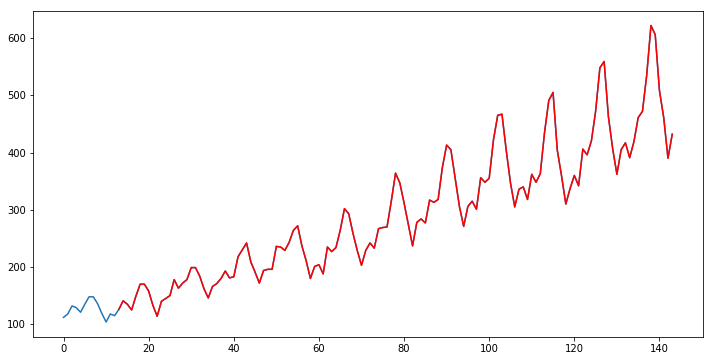

In [33]:
plt.figure(figsize=(12,6))
plt.plot(passengers['num_passengers'].values)
plt.plot(np.concatenate([np.full(13, np.nan), y_transformation['initial_res']]), color='r')
plt.show()

# 2. Экспоненциальное сглаживание

In [34]:
pigs = pd.read_csv('pigs.csv', index_col=0, parse_dates=True)
pigs = pigs[3:]

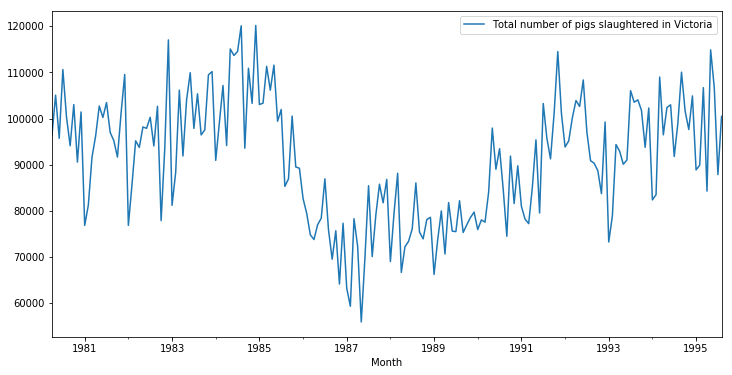

In [35]:
pigs.plot(figsize=(12,6))
plt.show()

Для прогнозирования с помощью экспоненциального сглаживания применяется следующий метод:

<font size="4">
$$\hat{y}_{t+1|t} = l_t$$

$$l_t = \alpha  y_t + (1-\alpha)  l_{t-1}, \quad \alpha \in [0,1] $$
</font>
Причем в качестве начального значения $l_0$ берется первое значение ряда $y$: 
<font size="4">
$$y_0 = l_0 $$
</font>

## 2.1 Функции преобразования экспоненциальным сглаживанием

In [36]:
def exponential_smoothing(y,alpha,level):
    l = [level]
    for t in range(1, len(y)):
        l.append(alpha * y[t] + (1 - alpha)* l[-1])
    return l

In [37]:
def exponential_smoothing(y, alpha, level):
    level_history = [level]
    for t in np.arange(1, len(y)):
        level_history.append(alpha*y[t] + (1 - alpha)*level_history[t-1])
    return level_history

Для получения значения на один месяц вперед, воспользуемся следующей формулой:

<font size="4">
$$\hat{y}_{T+1|T} = \sum_{i=0}^{T-1} \alpha \cdot (1-\alpha)^i y_{T-i} + (1-\alpha)^T \cdot l_0$$
</font>

In [42]:
def exponential_forecast(y, alpha, level):
    forecast = sum( [alpha * (1 - alpha) ** i * x + (1-alpha) ** len(y) * level for i, x in enumerate(reversed(y))] )
    return forecast

In [49]:
y = pigs.iloc[:,0].values #y = dt.y.values

alpha, level = 0.7, y[0] 

pigs['exp'] = exponential_smoothing(y, alpha, level)

In [52]:
xnew = pigs['Total number of pigs slaughtered in Victoria'].values.tolist()
xnew.append("no data")
xp = pigs.exp.values.tolist()
xp.insert(0,"no forecast")
xp

fig = go.Figure(data=[go.Table(
    header=dict(values=['A Scores', 'B Scores'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[xnew,xp], # 2nd column
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.update_layout(width=700, height=300)
fig.show()

In [58]:
pigs.head()

Total number of pigs slaughtered in Victoria          exp
Month                                                                
1980-04-01                                         96428   96428.0000
1980-05-01                                        105084  102487.2000
1980-06-01                                         95741   97764.8600
1980-07-01                                        110647  106782.3580
1980-08-01                                        100331  102266.4074

In [59]:
exponential_forecast(y,alpha,level)

98434.07565552287

## 2.2 Функции для высчитывания MSE

$$SSE=\sum_{t=1}^T (y_t-\hat{y}_{t|t-1})^2=\sum_{t=1}^T e_t^2$$

In [61]:
def exponential_smoothing_sse(y, alpha, level):
    level_history = [level]
    for t in np.arange(1, len(y)):
        level_history.append(alpha*y[t] + (1 - alpha)*level_history[t-1])
    return np.sum((y[1:] - level_history[:-1]) ** 2)

Для ошибки MSE мы начинаем со второго наблюдения $y$, для этого обрезаем у $y$ первый элемент, а у списка предсказаний - последний

In [66]:
def exponential_smoothing_mse(y, alpha, level):
    level_history = [level]
    for t in np.arange(1, len(y)):
        level_history.append(alpha*y[t] + (1 - alpha)*level_history[t-1])
    return np.sum((y[1:] - level_history[:-1]) ** 2)/(len(y) - 1)

In [68]:
def MSE(y,y_forecast):
    return np.square(np.subtract(y,y_forecast)).mean() 

def exponential_smoothing_mse(y,alpha,level):
    l = [level]
    for t in range(1, len(y)):
        l.append(alpha * y[t] + (1 - alpha)* l[-1])
    return MSE(y[1:], l[:-1])

In [70]:
from sklearn.metrics import mean_squared_error

def exponential_smoothing_mse(y,alpha,level):
    l = [level]
    for t in range(1, len(y)):
        l.append(alpha * y[t] + (1 - alpha)* l[-1])
    return mean_squared_error(y[1:],l[:-1])

In [73]:
es_mse = exponential_smoothing_mse(y,alpha,level)

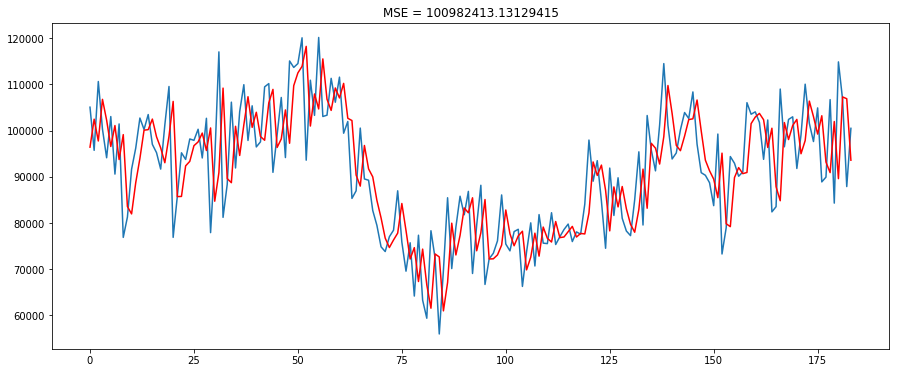

In [75]:
plt.figure(figsize=(15,6))
plt.plot(y[1:])
plt.plot(exponential_smoothing(y, alpha, y[0])[:-1], color='r')
plt.title('MSE = ' + str(es_mse))
plt.show()

## 2.3. Поиск оптимальных компонент

Для выбора оптимальных значений коэффициента сглаживания и начального уровня была реализована функция `exponential_smoothing_mse`.

In [77]:
res = minimize(lambda x: exponential_smoothing_mse(y, x[0], x[1]), [1, y[0]])
res

      fun: 83476672.97472079
 hess_inv: array([[2.67527776e-09, 1.84153024e-05],
       [1.84153024e-05, 4.52012169e+01]])
      jac: array([-838.,    0.])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 179
      nit: 10
     njev: 42
   status: 2
  success: False
        x: array([2.90544670e-01, 1.00813033e+05])

In [78]:
res.fun, res.x

(83476672.97472079, array([2.90544670e-01, 1.00813033e+05]))

In [79]:
best_alpha, best_level = res.x

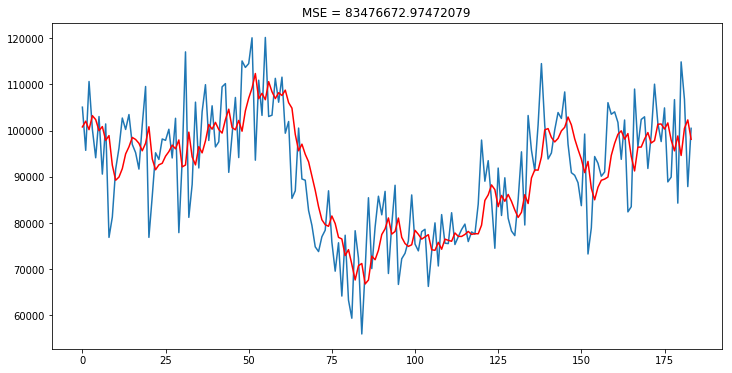

In [80]:
plt.figure(figsize=(12,6))
plt.plot(y[1:])
plt.plot(exponential_smoothing(y, best_alpha, best_level)[:-1], color='r')
plt.title('MSE = ' + str(res.fun))
plt.show()

# 3. Метод Хольта-Уинтерса

Метод Хольта-Уинтерса называют также методом тройного экспоненциального сглаживания, поскольку в его основе лежит как раз данный метод. Поэтому для реализации метода Хольта-Уинтерса возьмем за основу реализацию метода экспоненциального сглаживания.

In [81]:
austourists = pd.read_csv('austourists.csv', index_col=0, usecols=['time', 'value'])
austourists.head()

value
time              
2004.00  41.273599
2004.25  26.655862
2004.50  28.279859
2004.75  35.191153
2005.00  42.205664

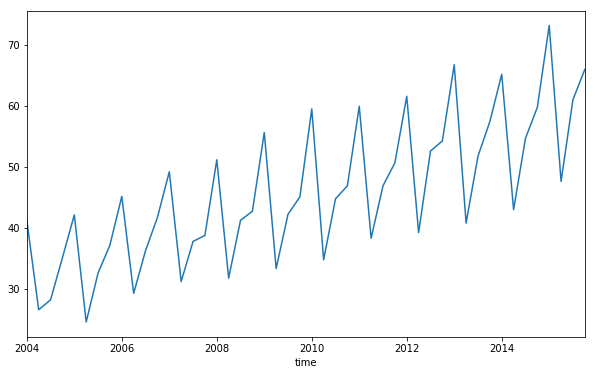

In [86]:
austourists.value.plot(figsize=(10, 6))
plt.show()

Начнем с метода Хольта. В качестве начального значения уровня возьмем первое значение ряда. В качестве начального значения тренда возьмем разность между вторым и первым значением.

In [83]:
def holt(y, alpha, beta):
    y_history = [y[0]]
    level, trend = y[0], y[1] - y[0]
    for t in np.arange(1, len(y)):
        last_level, level = level, alpha*y[t] + (1 - alpha)*(level + trend)
        trend = beta*(level - last_level) + (1 - beta)*trend
        y_history.append(level + trend)
    return y_history

In [84]:
y_tourists = austourists['value'].values

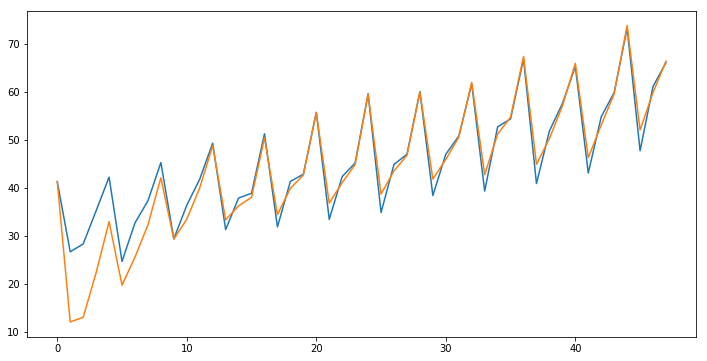

In [125]:
plt.figure(figsize=(12,6))
plt.plot(y_tourists)
plt.plot(holt(y_tourists, 0.8, 0.2))
plt.show()

## 3.1. Аддитивная сезонность

В модели Хольта-Уинтерса возможны два подхода в зависимости от характера поведения сезонной составляющей. Рассмотренный ранее  аддитивный метод применяется, когда сезонные колебания примерно постоянны по всему ряду. Аддитивный метод Хольта-Уинтерса:

<font size="4">
$$\hat{y}_{t+h\, |\, t}=l_t+h\, b_t+s_{t-m+h\bmod m }\, ,$$
$$l_t=\alpha\, (y_t-s_{t-m})+(1-\alpha)\, (l_{t-1}+b_{t-1}),$$
$$b_t=\beta\, (l_t-l_{t-1})+(1-\beta)\, b_{t-1},$$
$$s_t=\gamma\, (y_t-l_{t-1}-b_{t-1})+(1-\gamma)\, s_{t-m}\, .$$
</font>

$m$ - период сезонности

$s_i$ , $i \in 0, \ldots,s-1$ - сезонный профиль

$b_t$ - параметр тренда

$l_t$ - параметр прогноза, очищенный от влияния тренда и сезонности

In [89]:
alpha = 0.306

beta = 0.0003

gamma = 0.426

y = austourists.value.values

Тренд - изменение уровня ряда, плавное, долгосрочное

Сезонность - циклическое изменение уровня ряд  с постоянным периодом

Цикл - изменение уровня ряда с переменным периодом

Видно, что у нас период сезонности равен четырем, поэтому $m=4$

Начальный параметр прогноза - `l0 = y[m]-y[0]`

Начальный параметр тренда - `b0 = y[m]-y[0] `

Будем прогнозировать на один день, поэтому в формуле `h = 1`

Начальные значения сезонного профиля - берем первые четыре значения `y`

In [90]:
def holt_winters(y, alpha, beta, gamma, lag=4):
    y_history = [y[4]]
    level = y[4] - y[0]
    trend = (y[4] - y[0])
    seasonality = list(y[:4])
    
    for t in np.arange(lag, len(y)):
        last_level, level = level, alpha*(y[t] - seasonality[t-lag]) + (1-alpha)*(level + trend)
        last_trend, trend = trend, beta*(level-last_level) + (1-beta)*trend
        seasonality.append(gamma*(y[t] - last_level - last_trend) + (1-gamma)*seasonality[t-lag])
        y_history.append(level + trend + seasonality[t-lag+1])
    return y_history

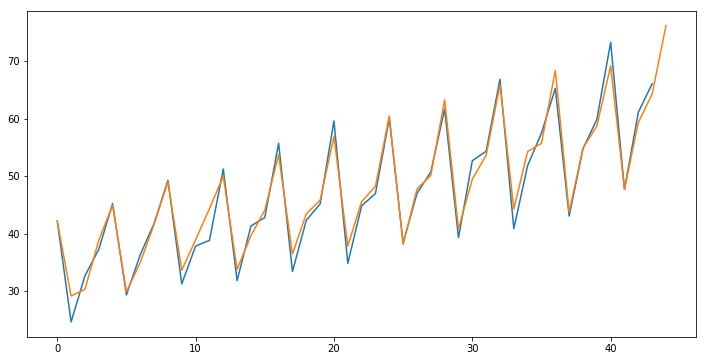

In [91]:
plt.figure(figsize=(12,6))
plt.plot(y_tourists[4:])
plt.plot(holt_winters(y_tourists, 0.3, 0.03, 0.4, lag=4))
plt.show()

### Еще реализация

In [92]:
def add_hw(alpha,beta,gamma,y):
    m = 4
    h = 1
    l = [y[4]-y[0]]
    b = [y[4]-y[0]]
    h = 1
    s = y[:m].tolist()
    arr = np.arange(m, len(y))
    y_pred = y.copy()
    prognose = 0

    for t in arr:
        lnew = alpha *( y[t] - s[t-m] ) + ( 1 - alpha ) * ( l[-1] + b[-1] )
        l.append( lnew )

        bnew = beta * ( l[-1] + l[-2] ) + ( 1 - beta ) * b[-1]
        b.append( bnew )

        snew = gamma * ( y[t] - l[-2] - b[-2] ) + ( 1 - gamma ) * s[t - m]
        s.append(snew)
        if t == len(y)-1:
            prognose = l[-1] + h * b[-1] + s[ -1 - m + (h % m)]
        else:
            y_pred[t + h] = l[-1] + h * b[-1] + s[ -1 - m + (h % m)]
    
    return y_pred,prognose

In [93]:
y_pred, prognose = add_hw(alpha,beta,gamma,y)

$$RMSE=\sqrt{\frac{1}{T-4}\sum_{t=5}^{T} (y_t-\hat{y}_t)^{2}}.$$

In [98]:
def RMSE(y,y_pred):
    return np.sqrt(sum((y[4:] - y_pred[:-4])**2)/len(y)-4)

In [99]:
austourists['hw'] = y_pred

In [100]:
RMSE(y,y_pred)

1.9045591791645688

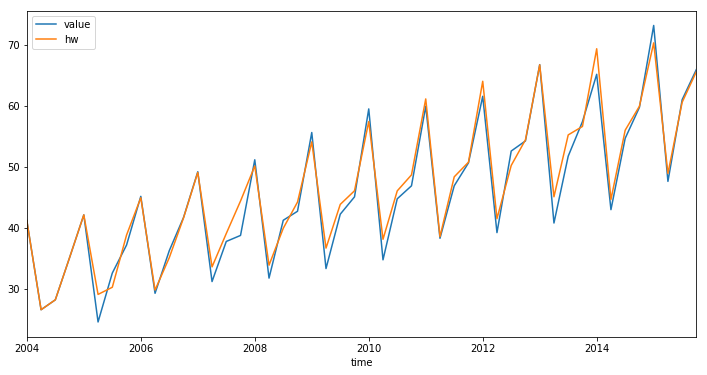

In [102]:
austourists[['value','hw']].plot(figsize=(12, 6))

## 3.2. Мультипликативная сезонность

В случае, когда сезонные колебания изменяются пропорционально уровню ряда, говорят о мультипликативной сезонности. В данном случае мультипликативный метод Хольта-Уинтерса является более предпочтительным:

<font size="4">
$$\hat{y}_{t+h\, |\, t}=(l_t+h\, b_t)\, s_{t-m+h\bmod m }\, ,$$
$$l_t=\alpha\, \frac{y_t}{s_{t-m}}+(1-\alpha)\, (l_{t-1}+b_{t-1}),$$
$$b_t=\beta\, (l_t-l_{t-1})+(1-\beta)\, b_{t-1},$$
$$s_t=\gamma\, \frac{y_t}{l_{t-1}+b_{t-1}}+(1-\gamma)\, s_{t-m}\, .$$
    </font>

In [107]:
y_tourists = austourists['value'].values

При аддитивном методе сезонная компонента $s_t$ выражается в абсолютных величинах в масштабе наблюдаемого ряда, а в уравнении уровня ряд сезонно корректируется путем вычитания из него сезонной компоненты. При использовании же мультипликативного метода сезонная компонента выражается в относительных единицах, а ряд корректируется путем деления значений на сезонную компоненту.

In [108]:
def holt_winters_add(y, alpha, beta, gamma, lag=4):
    y_history = [y[4]]
    level = y[4] - y[0]
    trend = (y[4] - y[0])
    seasonality = list(y[:4])
    
    for t in np.arange(lag, len(y)):
        last_level, level = level, alpha*y[t]/seasonality[t-lag] + (1-alpha)*(level + trend)
        last_trend, trend = trend, beta*(level-last_level) + (1-beta)*trend
        seasonality.append(gamma*y[t]/(last_level + last_trend) + (1-gamma)*seasonality[t-lag])
        y_history.append((level + trend)*seasonality[t-lag+1])
    return y_history

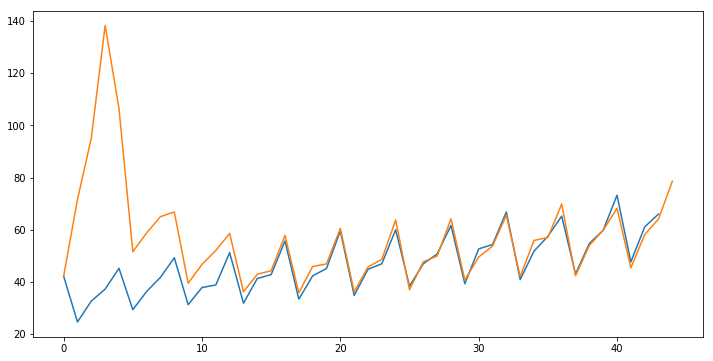

In [123]:
plt.figure(figsize=(12,6))
plt.plot(y_tourists[4:])
plt.plot(holt_winters_add(y_tourists, 0.1, 0.3, 0.9, lag=4))
plt.show()

In [114]:
def holt_winters_mse_with_l0(y,alpha,beta,gamma,level,trend,lag=4):
    y_history = [y[4]]
    seasonality = list(y[:4])
    
    for t in np.arange(lag, len(y)):
        last_level, level = level, alpha*y[t]/seasonality[t-lag] + (1-alpha)*(level + trend)
        last_trend, trend = trend, beta*(level-last_level) + (1-beta)*trend
        seasonality.append(gamma*y[t]/(last_level + last_trend) + (1-gamma)*seasonality[t-lag])
        y_history.append((level + trend)*seasonality[t-lag+1])
    return np.sum((y[4:] - y_history[:-1]) ** 2)

def holt_winters_add_new(y, alpha, beta, gamma,level,trend, lag=4):
    y_history = [y[4]]
    seasonality = list(y[:4])
    
    for t in np.arange(lag, len(y)):
        last_level, level = level, alpha*y[t]/seasonality[t-lag] + (1-alpha)*(level + trend)
        last_trend, trend = trend, beta*(level-last_level) + (1-beta)*trend
        seasonality.append(gamma*y[t]/(last_level + last_trend) + (1-gamma)*seasonality[t-lag])
        y_history.append((level + trend)*seasonality[t-lag+1])
    return y_history

In [116]:
res = minimize(lambda x: holt_winters_mse_with_l0(y_tourists, x[0], x[1], x[2],x[3],x[4]), [0, 0, 0,1,1])

c:\users\shiro\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning:

overflow encountered in square

c:\users\shiro\appdata\local\programs\python\python37\lib\site-packages\scipy\optimize\optimize.py:696: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\shiro\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning:

overflow encountered in square



In [117]:
res.fun, res.x

(280.2231579951801,
 array([ 0.69864364, -0.26814564,  0.7735128 ,  1.2876538 , -0.03076548]))

In [120]:
best_alpha, best_beta, best_gamme, best_l0, best_b0 = res.x

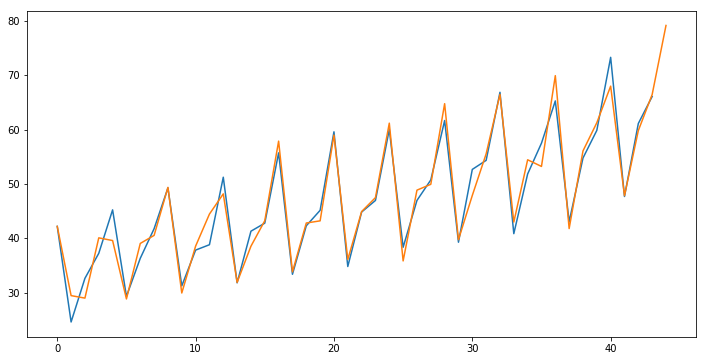

In [121]:
plt.figure(figsize=(12,6))
plt.plot(y_tourists[4:])
plt.plot(holt_winters_add_new(y_tourists, best_alpha, best_beta, best_gamme, best_l0, best_b0, lag=4))
plt.show()

В этом задании будем использовать данные о количестве ночей, проведенных иностранцами в гостинице Австралии `austourists.csv`.

<ol>
 
  <li>Реализуйте аддитивный метод Хольта-Уинтерса. Постройте прогноз на одну точку вперед при $\alpha=0.306, \beta=0.0003, \gamma=0.426$. Оцените качество модели с помощью метрики RMSE:</li>
$$RMSE=\sqrt{\frac{1}{T-4}\sum_{t=5}^{T} (y_t-\hat{y}_t)^{2}}.$$
 <p></p>
 <li>Реализуйте мультипликативный метод Хольта-Уинтерса. Постройте прогноз на одну точку вперед при $\alpha=0.441, \beta=0.03, \gamma=0.002$. Сравните качество результатов с полученными с помощью аддитивной модели.</li>

</ol>

# 4. Возможности библиотеки statsmodels

В библиотеке **Statsmodels** реализованы модели прогнозирования, в т. ч. модель Хольта-Уинтерса. Все рассмотренные ранее модели, в основе которых лежит метод экспоненциального сглаживания, реализованы в модуле `statsmodels.tsa.holtwinters`.

Функция `SimpleExpSmoothing` предназначена для построения простого экспоненциального сглживания. Для рядов с трендом можно воспользоваться функцией `Holt`. Модель Хольта-Уинтерса для рядов с сезонностью реализована в виде функции `ExponentialSmoothing`.

In [133]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

## 4.1. Экспоненциальное сглаживание

Построим модель экспоненциального сглаживания для того же ряда `pigs.csv`. Для этого необходимо инициализировать модель в отдельной переменной. Аргументом функции `SimpleExpSmoothing` выступает временной ряд.

In [136]:
pigs.drop('exp', axis=1, inplace=True)

In [140]:
ses = SimpleExpSmoothing(pigs)

In [141]:
pigs.index = pd.DatetimeIndex(pigs.index.values, freq='MS')
pigs.index = pd.DatetimeIndex(pigs.index.values, freq=pigs.index.inferred_freq)

In [142]:
ses1 = SimpleExpSmoothing(pigs).fit()
ses2 = SimpleExpSmoothing(pigs).fit(smoothing_level=best_alpha, initial_level=best_level, optimized=False)

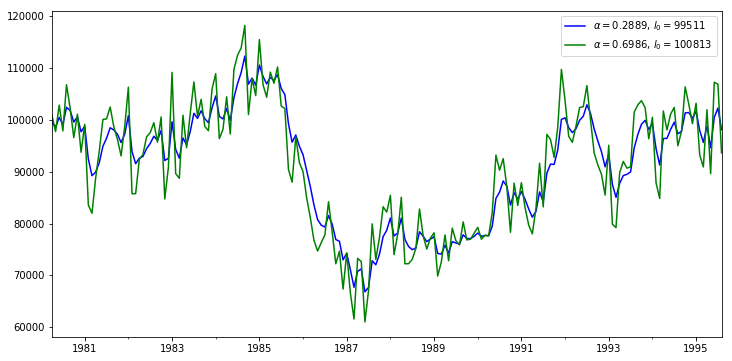

In [143]:
plt.figure(figsize=(12,6))
ses1.fittedvalues.rename(r'$\alpha=%.4f$'%ses1.model.params['smoothing_level'] + ", " + 
                         r'$l_0=%.f$'%ses1.model.params['initial_level']).plot(color='b', legend=True)
ses2.fittedvalues.rename(r'$\alpha=%.4f$'%ses2.model.params['smoothing_level'] + ", " + 
                         r'$l_0=%.f$'%ses2.model.params['initial_level']).plot(color='g', legend=True)

plt.show()

In [144]:
ses1_forecast = ses1.forecast(12)
ses2_forecast = ses2.forecast(12)

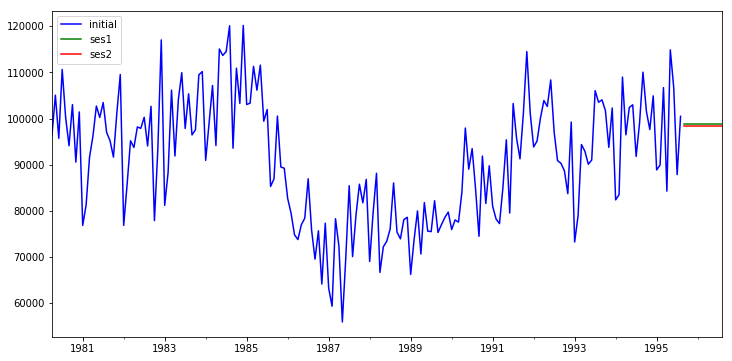

In [145]:
plt.figure(figsize=(12,6))
pigs.iloc[:,0].rename('initial').plot(color='b', legend=True)
ses1_forecast.rename('ses1').plot(color='g', legend=True)
ses2_forecast.rename('ses2').plot(color='r', legend=True)
plt.show()

In [146]:
ses1.predict(start='1995-09-01', end='1996-08-01')

1995-09-01    98824.298231
1995-10-01    98824.298231
1995-11-01    98824.298231
1995-12-01    98824.298231
1996-01-01    98824.298231
1996-02-01    98824.298231
1996-03-01    98824.298231
1996-04-01    98824.298231
1996-05-01    98824.298231
1996-06-01    98824.298231
1996-07-01    98824.298231
1996-08-01    98824.298231
Freq: MS, dtype: float64